# Workspace Solution

In [ ]:
#| default_exp workspace_solution

In [ ]:
#| include: false
%load_ext autoreload
%autoreload 2

You are welcome to use this coding environment to train your controller for the project. Follow the instructions below to get started!

## 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [ ]:
# This is not implemented yet and the environment needs to be manually set up
#!pip -q install ./python-environment

The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [ ]:
#| export
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from feedback_control.simple_pendulum import *
from feedback_control.dc_motor import *

In [ ]:
#| include: false
from IPython.display import Image
from IPython.display import HTML

# To support animations
from matplotlib import animation, rc

In [ ]:
#| hide
# This is equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
rc('font', **{'family' : 'DejaVu Sans', 'weight' : 'normal', 'size'   : 22})

## 2. Simulate an untuned PID controller

<IPython.core.display.Javascript object>


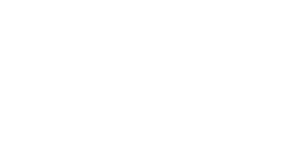

In [ ]:
#%%capture
# %matplotlib notebook
pendulum = Pendulum(theta_0=np.radians(0), 
                    theta_dot_0=0, 
                    params=PendulumParameters(b=0.2))

motor = DCMotor(x0=np.array([[0], [0], [0]]), # theta, theta_dot, current
                params=DCMotorParams())

pid = PID(Kp=1000, 
          Kd=500, 
          Ki=0)
# pid = PID(Kp=0, 
#           Kd=0, 
#           Ki=0)

# connect the motor to the pendulum (effectively it sets the load on the motor)
motor.connect_to(pendulum)

t0, tf, dt = 0, 10, 1./30 # time
sim = Simulator(pendulum, motor, pid)

sim.y_des(10) # desired final value in degrees
results = sim.run(t0, tf, dt)

# show an animation of the results
ap = AnimateControlledPendulum(sim)
ap.start_animation(t0, tf, dt)

### Plot more information

And we can also dig deeper and verify how the motor is behaving:

<IPython.core.display.Javascript object>


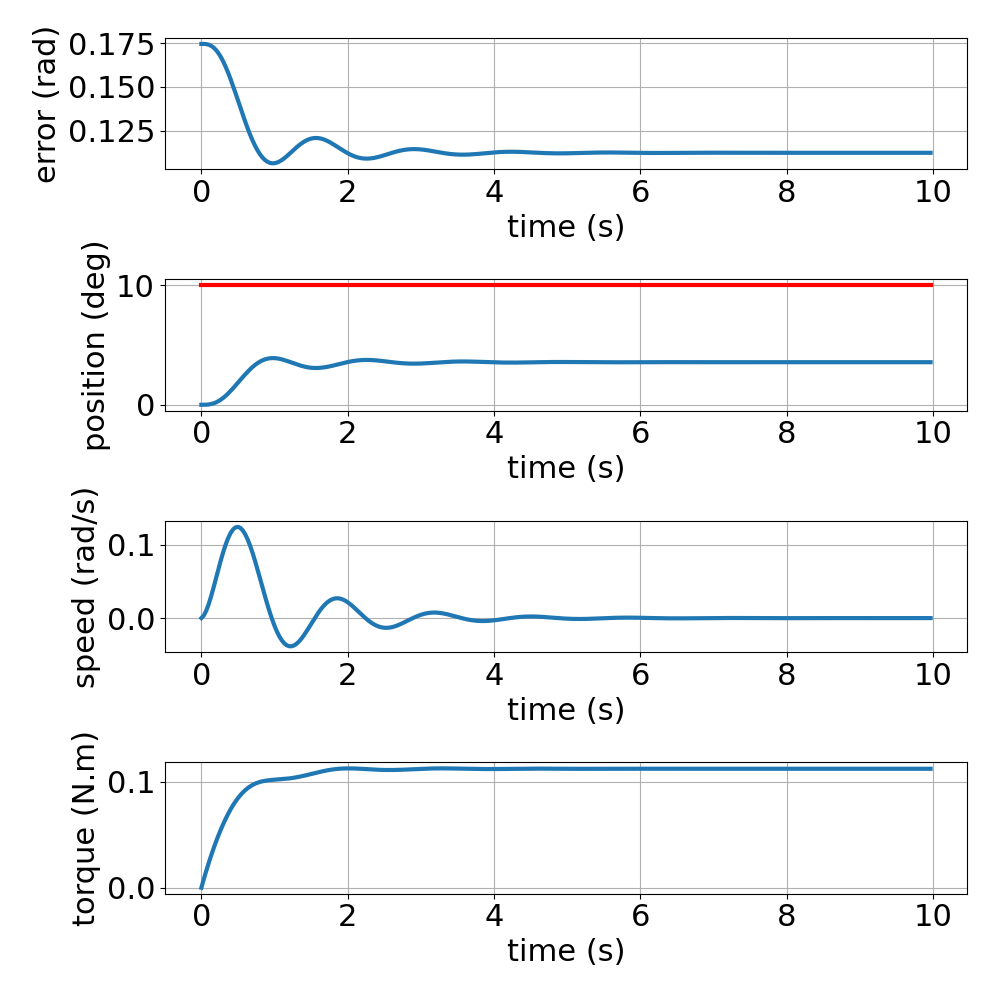

In [ ]:
# %matplotlib inline
fig, axs = plt.subplots(len(results.keys())-1, 1, figsize=(10,10))

for index, key in enumerate(results.keys()):
    if key == 'time (s)': continue
    if key == 'position (rad)':
        axs[index].plot(results['time (s)'], np.degrees(results[key]), linewidth=3)
        axs[index].plot(results['time (s)'], sim.y_des*np.ones(results['time (s)'].shape), color='r', linewidth=3)
        key = 'position (deg)'
    else:
        axs[index].plot(results['time (s)'], results[key], linewidth=3)
    axs[index].set_xlabel('time (s)')
    axs[index].set_ylabel(key)
    axs[index].grid()

plt.tight_layout()

## 3. It's Your Turn!

Now it's your turn to train your own controller to solve the project!  

A few **important notes**:
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will be able to watch the results of using the controller through a simple animation. You will not be able to see how the pendulum reacts to control in real-time as the animation is played after the simulation is finished.
- If you have have a `TypeError: 'Line2D' object is not iterable` error when running the animation, please make sure you have run `%matplotlib notebook`.


## 4. Solution steps

We can use Ziegler Nichols to start our analysis and verify what could be good PID parameters.

- We close the loop with a Proportional controller only and find for the gain that would achieve pure oscillations. This would give us the following parameters.
  - $K^*=6435$
  - $T_p^*= 1.7$
  
- From these parameters we can set:
| $R(s)$ | $K_p$     | $\tau_I$ | $\tau_d$ |
|--------|-------    |----------|----------|
| $P$    | $0.5K^*$  |          |          |
| $PI$   | $0.45K^*$ | $0.8T_p^*$ | |
| $PID$  | $0.6K^*$  | $0.5T_p^*$ | $0.125T_p^*$ |

For a PI controller
- $Kp = 0.45*K^* = 2895.75$
- $Ki = 0.8T_p^* = 1.36$

For a PID controller
- $Kp = 0.6*K^* = 3861.0$
- $Ki = 0.5T_p^* = 0.85$
- $Kd = 0.125T_p^* = 0.2125$

In [ ]:
#%%capture
# %matplotlib notebook
pendulum = Pendulum(theta_0=np.radians(0), 
                    theta_dot_0=0, 
                    params=PendulumParameters(b=0.2))

motor = DCMotor(x0=np.array([[0], [0], [0]]), # theta, theta_dot, current
                params=DCMotorParams())

pid = PID(Kp=6435, 
          Kd=0, 
          Ki=0)
# pid = PID(Kp=0, 
#           Kd=0, 
#           Ki=0)

# connect the motor to the pendulum (effectively it sets the load on the motor)
motor.connect_to(pendulum)

t0, tf, dt = 0, 10, 1./30 # time
sim = Simulator(pendulum, motor, pid)

sim.y_des(10) # desired final value in degrees
results = sim.run(t0, tf, dt)

# show an animation of the results
ap = AnimateControlledPendulum(sim)
ap.start_animation(t0, tf, dt)

We can plot as before the motor behaviour to verify how it is oscillating

In [ ]:
# %matplotlib inline
fig, axs = plt.subplots(len(results.keys())-1, 1, figsize=(10,10))

for index, key in enumerate(results.keys()):
    if key == 'time (s)': continue
    if key == 'position (rad)':
        axs[index].plot(results['time (s)'], np.degrees(results[key]), linewidth=3)
        axs[index].plot(results['time (s)'], sim.y_des*np.ones(results['time (s)'].shape), color='r', linewidth=3)
        key = 'position (deg)'
    else:
        axs[index].plot(results['time (s)'], results[key], linewidth=3)
    axs[index].set_xlabel('time (s)')
    axs[index].set_ylabel(key)
    axs[index].grid()

plt.tight_layout()

The period of oscillation is obtained as:

In [ ]:
value_threshold = .0001 # this is empirically calculated
# max_time = np.where(results['position (rad)'] == np.max(results['position (rad)']))[0][0]
# max_time
# print(f"t0: {results['time (s)'][240]} s")

max_time = np.where(abs(results['position (rad)'] - np.amax(results['position (rad)'])) <= value_threshold)
print(f"max times: {results['time (s)'][max_time]} s")
print(f"Critical Period: {abs(results['time (s)'][max_time][0]-results['time (s)'][max_time][1])} s")

In [ ]:
fig, axs = plt.subplots(1, figsize=(10,10))
plt.plot(results['time (s)'], results['position (rad)'])
plt.grid()
plt.plot(results['time (s)'][max_time][0], np.max(results['position (rad)']), marker='.', color='b', markersize=12)
plt.plot(results['time (s)'][max_time][1], np.max(results['position (rad)']), marker='.', color='r', markersize=12)

### Apply PID coefficients

We can now try it again:

In [ ]:
#%%capture
# %matplotlib notebook
pendulum = Pendulum(theta_0=np.radians(0), 
                    theta_dot_0=0, 
                    params=PendulumParameters(b=0.2))

motor = DCMotor(x0=np.array([[0], [0], [0]]), # theta, theta_dot, current
                params=DCMotorParams())

# pid = PID(Kp=2895.75, 
#           Kd=0, 
#           Ki=1.36)

pid = PID(Kp=3861., 
          Kd=0.2125, 
          Ki=0.85)



# connect the motor to the pendulum (effectively it sets the load on the motor)
motor.connect_to(pendulum)

t0, tf, dt = 0, 10, 1./30 # time
sim = Simulator(pendulum, motor, pid)

sim.y_des(10) # desired final value in degrees
results = sim.run(t0, tf, dt)

# show an animation of the results
ap = AnimateControlledPendulum(sim)
ap.start_animation(t0, tf, dt)

### Plot performance results

In [ ]:
# %matplotlib inline
fig, axs = plt.subplots(len(results.keys())-1, 1, figsize=(10,10))

for index, key in enumerate(results.keys()):
    if key == 'time (s)': continue
    if key == 'position (rad)':
        axs[index].plot(results['time (s)'], np.degrees(results[key]), linewidth=3)
        axs[index].plot(results['time (s)'], sim.y_des*np.ones(results['time (s)'].shape), color='r', linewidth=3)
        key = 'position (deg)'
    else:
        axs[index].plot(results['time (s)'], results[key], linewidth=3)
    axs[index].set_xlabel('time (s)')
    axs[index].set_ylabel(key)
    axs[index].grid()

plt.tight_layout()

We can now fine tune it:

In [ ]:
#%%capture
# %matplotlib notebook
pendulum = Pendulum(theta_0=np.radians(0), 
                    theta_dot_0=0, 
                    params=PendulumParameters(b=0.2))

motor = DCMotor(x0=np.array([[0], [0], [0]]), # theta, theta_dot, current
                params=DCMotorParams())

# pid = PID(Kp=2895.75, 
#           Kd=0, 
#           Ki=1.36)

pid = PID(Kp=3861., 
          Kd=20, 
          Ki=1000)



# connect the motor to the pendulum (effectively it sets the load on the motor)
motor.connect_to(pendulum)

t0, tf, dt = 0, 10, 1./30 # time
sim = Simulator(pendulum, motor, pid)

sim.y_des(10) # desired final value in degrees
results = sim.run(t0, tf, dt)

# show an animation of the results
ap = AnimateControlledPendulum(sim)
ap.start_animation(t0, tf, dt)

In [ ]:
# %matplotlib inline
fig, axs = plt.subplots(len(results.keys())-1, 1, figsize=(10,10))

for index, key in enumerate(results.keys()):
    if key == 'time (s)': continue
    if key == 'position (rad)':
        axs[index].plot(results['time (s)'], np.degrees(results[key]), linewidth=3)
        axs[index].plot(results['time (s)'], sim.y_des*np.ones(results['time (s)'].shape), color='r', linewidth=3)
        key = 'position (deg)'
    else:
        axs[index].plot(results['time (s)'], results[key], linewidth=3)
    axs[index].set_xlabel('time (s)')
    axs[index].set_ylabel(key)
    axs[index].grid()

plt.tight_layout()

--------

## Using the analysis done in assignment 2

In [ ]:
#%%capture
# %matplotlib notebook
pendulum = Pendulum(theta_0=np.radians(0), 
                    theta_dot_0=0, 
                    params=PendulumParameters(b=0.02))

motor = DCMotor(x0=np.array([[0], [0], [0]]), # theta, theta_dot, current
                params=DCMotorParams())

# pid = PID(Kp=2895.75, 
#           Kd=0, 
#           Ki=1.36)


pid = PID(Kp=5.144, 
          Kd=101.6, 
          Ki=0.0635)



# connect the motor to the pendulum (effectively it sets the load on the motor)
motor.connect_to(pendulum)

t0, tf, dt = 0, 10, 1./30 # time
sim = Simulator(pendulum, motor, pid)

sim.y_des(10) # desired final value in degrees
results = sim.run(t0, tf, dt)

# show an animation of the results
ap = AnimateControlledPendulum(sim)
ap.start_animation(t0, tf, dt)

In [ ]:
# %matplotlib inline
fig, axs = plt.subplots(len(results.keys())-1, 1, figsize=(10,10))

for index, key in enumerate(results.keys()):
    if key == 'time (s)': continue
    if key == 'position (rad)':
        axs[index].plot(results['time (s)'], np.degrees(results[key]), linewidth=3)
        axs[index].plot(results['time (s)'], sim.y_des*np.ones(results['time (s)'].shape), color='r', linewidth=3)
        key = 'position (deg)'
    else:
        axs[index].plot(results['time (s)'], results[key], linewidth=3)
    axs[index].set_xlabel('time (s)')
    axs[index].set_ylabel(key)
    axs[index].grid()

plt.tight_layout()